In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

# Function to generate random dates
def random_dates(start, end, n=10):
    return [start + timedelta(days=np.random.randint(0, (end - start).days)) for _ in range(n)]

# Parameters
num_records = 10000
start_date = datetime.now() - timedelta(days=4*365)
end_date = datetime.now()

# Expanded categories
business_lines = [
    "Retail", "Corporate Banking", "Investment Banking", "Insurance",
    "Wealth Management", "Asset Management", "Private Banking",
    "Credit Card Services", "Mortgage Lending", "Financial Advisory"
]

event_types = [
    "Fraud", "System Failure", "Theft", "Compliance", "Natural Disaster",
    "Cyber Attack", "Market Risk", "Operational Error", "Vendor Risk", "Regulatory Violation"
]

# Generate data
data = {
    "Date": random_dates(start_date, end_date, num_records),
    "Unique Event ID": [f"EID{str(i).zfill(5)}" for i in range(num_records)],
    "Event Type": np.random.choice(event_types, num_records),
    "Business Line": np.random.choice(business_lines, num_records),
    "Event Description": np.random.choice(
        [
            "Unauthorized transaction", "Server downtime", "Lost assets", 
            "Regulatory fines", "Data breach", "Network failure", 
            "Inadequate compliance", "Financial misstatement", 
            "Supplier issues", "Internal fraud"
        ],
        num_records
    ),
    "Net Loss Amount": np.random.choice(
        [np.random.uniform(-10000, 0) for _ in range(num_records // 2)] + 
        [np.random.uniform(0, 10000) for _ in range(num_records // 2)],
        num_records
    )
}

# Create DataFrame
df = pd.DataFrame(data)

# Add a Year column
df['Year'] = df['Date'].dt.year

In [7]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    # Simulate event counts (frequency) using Poisson distribution
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Simulate severity amounts (loss) using Log-Normal distribution
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    # Total losses = frequency * severity
    total_losses = simulated_event_counts * simulated_loss_amounts
    # Calculate VaR
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    # Simulate event counts using Poisson distribution
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    # Calculate VaR
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year and business line
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        # Filter data for the specific year and business line
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        # Total event counts and net loss
        total_event_count = bl_data.shape[0]
        total_net_loss = bl_data['Net Loss Amount'].sum()
        
        # Frequency parameter (Poisson λ)
        frequency_lambda = total_event_count / 1  # Events per year
        
        # Severity parameters (Log-Normal distribution)
        positive_losses = bl_data[bl_data['Net Loss Amount'] > 0]['Net Loss Amount']
        if positive_losses.empty:
            print(f"No positive losses for {business_line} in {year}. Skipping.")
            continue
        severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
        
        # Calculate VaR for Net Loss
        var_net_loss = calculate_net_loss_var(
            frequency_lambda=frequency_lambda,
            severity_shape=severity_shape,
            severity_scale=severity_scale,
            severity_loc=severity_loc,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Calculate VaR for Event Count
        var_event_count = calculate_event_count_var(
            frequency_lambda=frequency_lambda,
            confidence_level=confidence_level,
            n_simulations=n_simulations
        )
        
        # Append results
        results.append({
            'Year': year,
            'Business Line': business_line,
            'Total Net Loss': total_net_loss,
            'Total Event Count': total_event_count,
            'VaR Net Loss (99.9%)': var_net_loss,
            'VaR Event Count (99.9%)': var_event_count
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


    Year         Business Line  Total Net Loss  Total Event Count  \
0   2021    Investment Banking    14888.328732                228   
1   2021    Financial Advisory   -40865.052192                267   
2   2021     Corporate Banking  -155245.996109                264   
3   2021     Wealth Management    38788.016635                269   
4   2021      Asset Management   -10554.428223                259   
5   2021       Private Banking   -16360.014481                254   
6   2021             Insurance    42524.012453                266   
7   2021      Mortgage Lending   130123.253783                282   
8   2021                Retail   -25914.413844                262   
9   2021  Credit Card Services   -30027.265327                245   
10  2022    Investment Banking    80983.758280                257   
11  2022     Wealth Management    98691.620132                235   
12  2022  Credit Card Services    47102.153135                229   
13  2022       Private Banking    

In [8]:
results_df

,Year,Business Line,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Investment Banking,14888.328732,228,3.385742e+06,273.000
1,2021,Financial Advisory,-40865.052192,267,3.709498e+06,318.001
2,2021,Corporate Banking,-155245.996109,264,6.429621e+06,319.001
3,2021,Wealth Management,38788.016635,269,3.897438e+06,321.000
4,2021,Asset Management,-10554.428223,259,3.816373e+06,310.000
5,2021,Private Banking,-16360.014481,254,3.663257e+06,304.001
6,2021,Insurance,42524.012453,266,3.840219e+06,317.000
7,2021,Mortgage Lending,130123.253783,282,4.213108e+06,333.000
8,2021,Retail,-25914.413844,262,4.592797e+06,311.001
9,2021,Credit Card Services,-30027.265327,245,3.504200e+06,292.001


In [9]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line}, {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Append results
            results.append({
                'Year': year,
                'Business Line': business_line,
                'Event Type': event_type,
                'Total Net Loss': total_net_loss,
                'Total Event Count': total_event_count,
                'VaR Net Loss (99.9%)': var_net_loss,
                'VaR Event Count (99.9%)': var_event_count
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year       Business Line            Event Type  Total Net Loss  \
0    2021  Investment Banking                 Theft    36792.615185   
1    2021  Investment Banking            Compliance    15593.681073   
2    2021  Investment Banking           Market Risk   -20254.291454   
3    2021  Investment Banking                 Fraud    -9084.131886   
4    2021  Investment Banking     Operational Error   -11286.037162   
..    ...                 ...                   ...             ...   
395  2024   Corporate Banking           Market Risk    23027.663418   
396  2024   Corporate Banking                 Fraud    14888.203002   
397  2024   Corporate Banking  Regulatory Violation   -56290.761352   
398  2024   Corporate Banking                 Theft    25149.100750   
399  2024   Corporate Banking     Operational Error    -9832.745851   

     Total Event Count  VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0                   23          1.959155e+17                   38.000  
1  

In [10]:
results_df

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Investment Banking,Theft,36792.615185,23,1.959155e+17,38.000
1,2021,Investment Banking,Compliance,15593.681073,18,2.880196e+19,32.000
2,2021,Investment Banking,Market Risk,-20254.291454,21,8.592602e+17,36.000
3,2021,Investment Banking,Fraud,-9084.131886,21,5.602653e+17,36.000
4,2021,Investment Banking,Operational Error,-11286.037162,23,1.754723e+19,39.000
...,...,...,...,...,...,...,...
395,2024,Corporate Banking,Market Risk,23027.663418,23,4.846738e+17,40.000
396,2024,Corporate Banking,Fraud,14888.203002,23,1.419028e+17,39.001
397,2024,Corporate Banking,Regulatory Violation,-56290.761352,17,3.918074e+19,30.000
398,2024,Corporate Banking,Theft,25149.100750,18,4.892538e+17,32.000


In [11]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    for business_line in yearly_data['Business Line'].unique():
        bl_data = yearly_data[yearly_data['Business Line'] == business_line]
        
        for event_type in bl_data['Event Type'].unique():
            et_data = bl_data[bl_data['Event Type'] == event_type]
            
            # Total event counts and net loss
            total_event_count = et_data.shape[0]
            total_net_loss = et_data['Net Loss Amount'].sum()
            
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per year
            
            # Severity parameters (Log-Normal distribution)
            positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line}, {event_type} in {year}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
            
            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
            
            # Append results
            results.append({
                'Year': year,
                'Business Line': business_line,
                'Event Type': event_type,
                'Total Net Loss': total_net_loss,
                'Total Event Count': total_event_count,
                'VaR Net Loss (99.9%)': var_net_loss,
                'VaR Event Count (99.9%)': var_event_count
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


     Year       Business Line            Event Type  Total Net Loss  \
0    2021  Investment Banking                 Theft    36792.615185   
1    2021  Investment Banking            Compliance    15593.681073   
2    2021  Investment Banking           Market Risk   -20254.291454   
3    2021  Investment Banking                 Fraud    -9084.131886   
4    2021  Investment Banking     Operational Error   -11286.037162   
..    ...                 ...                   ...             ...   
395  2024   Corporate Banking           Market Risk    23027.663418   
396  2024   Corporate Banking                 Fraud    14888.203002   
397  2024   Corporate Banking  Regulatory Violation   -56290.761352   
398  2024   Corporate Banking                 Theft    25149.100750   
399  2024   Corporate Banking     Operational Error    -9832.745851   

     Total Event Count  VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0                   23          3.653825e+17                   39.000  
1  

In [12]:
results_df

,Year,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,Investment Banking,Theft,36792.615185,23,3.653825e+17,39.000
1,2021,Investment Banking,Compliance,15593.681073,18,1.356078e+18,33.000
2,2021,Investment Banking,Market Risk,-20254.291454,21,3.647174e+17,37.001
3,2021,Investment Banking,Fraud,-9084.131886,21,3.078022e+17,38.000
4,2021,Investment Banking,Operational Error,-11286.037162,23,4.014957e+18,39.000
...,...,...,...,...,...,...,...
395,2024,Corporate Banking,Market Risk,23027.663418,23,1.581153e+17,39.000
396,2024,Corporate Banking,Fraud,14888.203002,23,2.190805e+17,40.000
397,2024,Corporate Banking,Regulatory Violation,-56290.761352,17,1.510391e+19,31.000
398,2024,Corporate Banking,Theft,25149.100750,18,3.303489e+17,33.000


In [13]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, quarter, business line, and event type
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Extract quarter from the 'Date' column
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
    
    for quarter in yearly_data['Quarter'].unique():
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
            
            for event_type in bl_data['Event Type'].unique():
                et_data = bl_data[bl_data['Event Type'] == event_type]
                
                # Total event counts and net loss
                total_event_count = et_data.shape[0]
                total_net_loss = et_data['Net Loss Amount'].sum()
                
                # Frequency parameter (Poisson λ)
                frequency_lambda = total_event_count / 1  # Events per quarter (assuming each row represents an event)
                
                # Severity parameters (Log-Normal distribution)
                positive_losses = et_data[et_data['Net Loss Amount'] > 0]['Net Loss Amount']
                if positive_losses.empty:
                    print(f"No positive losses for {business_line}, {event_type} in {year}, Q{quarter}. Skipping.")
                    continue
                severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
                # Calculate VaR for Net Loss
                var_net_loss = calculate_net_loss_var(
                    frequency_lambda=frequency_lambda,
                    severity_shape=severity_shape,
                    severity_scale=severity_scale,
                    severity_loc=severity_loc,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Calculate VaR for Event Count
                var_event_count = calculate_event_count_var(
                    frequency_lambda=frequency_lambda,
                    confidence_level=confidence_level,
                    n_simulations=n_simulations
                )
                
                # Append results
                results.append({
                    'Year': year,
                    'Quarter': quarter,
                    'Business Line': business_line,
                    'Event Type': event_type,
                    'Total Net Loss': total_net_loss,
                    'Total Event Count': total_event_count,
                    'VaR Net Loss (99.9%)': var_net_loss,
                    'VaR Event Count (99.9%)': var_event_count
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\1100887062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runt

No positive losses for Corporate Banking, Vendor Risk in 2021, Q1. Skipping.
No positive losses for Financial Advisory, Cyber Attack in 2021, Q1. Skipping.
No positive losses for Financial Advisory, Compliance in 2021, Q1. Skipping.
No positive losses for Insurance, Regulatory Violation in 2021, Q1. Skipping.
No positive losses for Asset Management, Fraud in 2021, Q1. Skipping.
No positive losses for Financial Advisory, Market Risk in 2021, Q4. Skipping.
No positive losses for Investment Banking, Fraud in 2021, Q4. Skipping.
No positive losses for Private Banking, Regulatory Violation in 2021, Q4. Skipping.
No positive losses for Credit Card Services, Compliance in 2021, Q3. Skipping.
No positive losses for Investment Banking, Compliance in 2021, Q2. Skipping.
No positive losses for Insurance, Compliance in 2021, Q2. Skipping.
No positive losses for Credit Card Services, Operational Error in 2021, Q2. Skipping.
No positive losses for Financial Advisory, Cyber Attack in 2021, Q2. Skippi

C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\1100887062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runti

No positive losses for Private Banking, Theft in 2022, Q1. Skipping.
No positive losses for Retail, Natural Disaster in 2022, Q1. Skipping.
No positive losses for Corporate Banking, Compliance in 2022, Q1. Skipping.
No positive losses for Mortgage Lending, Cyber Attack in 2022, Q1. Skipping.
No positive losses for Wealth Management, Theft in 2022, Q1. Skipping.
No positive losses for Credit Card Services, Vendor Risk in 2022, Q1. Skipping.
No positive losses for Wealth Management, Fraud in 2022, Q2. Skipping.
No positive losses for Wealth Management, Operational Error in 2022, Q2. Skipping.
No positive losses for Private Banking, Fraud in 2022, Q2. Skipping.
No positive losses for Credit Card Services, Operational Error in 2022, Q2. Skipping.
No positive losses for Credit Card Services, System Failure in 2022, Q2. Skipping.
No positive losses for Credit Card Services, Vendor Risk in 2022, Q4. Skipping.
No positive losses for Private Banking, Regulatory Violation in 2022, Q4. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\1100887062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: divide by zero encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runt

No positive losses for Wealth Management, Natural Disaster in 2023, Q2. Skipping.
No positive losses for Corporate Banking, Fraud in 2023, Q2. Skipping.
No positive losses for Investment Banking, Compliance in 2023, Q1. Skipping.
No positive losses for Investment Banking, Operational Error in 2023, Q1. Skipping.
No positive losses for Wealth Management, Market Risk in 2023, Q1. Skipping.
No positive losses for Private Banking, Compliance in 2023, Q1. Skipping.
No positive losses for Corporate Banking, Cyber Attack in 2023, Q1. Skipping.
No positive losses for Wealth Management, Theft in 2023, Q4. Skipping.
No positive losses for Corporate Banking, Vendor Risk in 2023, Q4. Skipping.
No positive losses for Wealth Management, Regulatory Violation in 2023, Q3. Skipping.
No positive losses for Credit Card Services, Natural Disaster in 2023, Q3. Skipping.
No positive losses for Insurance, Compliance in 2023, Q3. Skipping.
No positive losses for Mortgage Lending, Fraud in 2023, Q3. Skipping.


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\1100887062.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6554: RuntimeWarning: invalid value encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6423: RuntimeWarning: invalid value encountered in log
  lambda x, s: (-np.log(x)**2 / (2 * s**2)
C:\Users\Himanshu Singh\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_continuous_distns.py:6424: Runti

No positive losses for Corporate Banking, Cyber Attack in 2024, Q1. Skipping.
No positive losses for Wealth Management, Vendor Risk in 2024, Q3. Skipping.
No positive losses for Financial Advisory, Market Risk in 2024, Q3. Skipping.
No positive losses for Private Banking, Natural Disaster in 2024, Q3. Skipping.
No positive losses for Corporate Banking, Compliance in 2024, Q3. Skipping.
No positive losses for Mortgage Lending, System Failure in 2024, Q3. Skipping.
No positive losses for Private Banking, Operational Error in 2024, Q2. Skipping.
No positive losses for Mortgage Lending, System Failure in 2024, Q2. Skipping.
No positive losses for Credit Card Services, Regulatory Violation in 2024, Q2. Skipping.
No positive losses for Asset Management, Market Risk in 2024, Q2. Skipping.
No positive losses for Insurance, Theft in 2024, Q4. Skipping.
No positive losses for Insurance, Natural Disaster in 2024, Q4. Skipping.
No positive losses for Credit Card Services, Vendor Risk in 2024, Q4. 

In [14]:
results_df

,Year,Quarter,Business Line,Event Type,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Investment Banking,Theft,-15579.114639,7,5.582223e+04,16.000
1,2021,1,Investment Banking,Market Risk,-14349.476122,7,5.114101e+22,16.000
2,2021,1,Investment Banking,Fraud,-14651.564906,6,3.502545e+19,15.000
3,2021,1,Investment Banking,System Failure,-70.412031,4,8.067414e+17,12.000
4,2021,1,Investment Banking,Operational Error,-1296.483689,4,1.925812e+21,11.001
...,...,...,...,...,...,...,...,...
1516,2024,4,Mortgage Lending,Compliance,-752.261553,2,5.219055e+04,8.000
1517,2024,4,Mortgage Lending,Regulatory Violation,18232.552134,5,1.989472e+22,13.000
1518,2024,4,Mortgage Lending,Theft,-3081.084929,7,9.645259e+22,16.001
1519,2024,4,Mortgage Lending,Operational Error,3972.885746,4,3.526943e+20,11.001


In [15]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to calculate VaR for Net Loss using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to calculate VaR for Event Counts using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare results
results = []

# Define confidence level and number of simulations
confidence_level = 0.999
n_simulations = 10000

# Loop through each year, quarter, and business line
for year in range(2021, 2025):
    yearly_data = df[df['Year'] == year]
    
    # Extract quarter from the 'Date' column
    yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
    
    for quarter in yearly_data['Quarter'].unique():
        quarterly_data = yearly_data[yearly_data['Quarter'] == quarter]
        
        for business_line in quarterly_data['Business Line'].unique():
            bl_data = quarterly_data[quarterly_data['Business Line'] == business_line]
                
            # Total event counts and net loss
            total_event_count = bl_data.shape[0]
            total_net_loss = bl_data['Net Loss Amount'].sum()
                
            # Frequency parameter (Poisson λ)
            frequency_lambda = total_event_count / 1  # Events per quarter (assuming each row represents an event)
                
            # Severity parameters (Log-Normal distribution)
            positive_losses = bl_data[bl_data['Net Loss Amount'] > 0]['Net Loss Amount']
            if positive_losses.empty:
                print(f"No positive losses for {business_line} in {year}, Q{quarter}. Skipping.")
                continue
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)
                
            # Calculate VaR for Net Loss
            var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
                
            # Calculate VaR for Event Count
            var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda,
                confidence_level=confidence_level,
                n_simulations=n_simulations
            )
                
            # Append results
            results.append({
                'Year': year,
                'Quarter': quarter,
                'Business Line': business_line,
                'Total Net Loss': total_net_loss,
                'Total Event Count': total_event_count,
                'VaR Net Loss (99.9%)': var_net_loss,
                'VaR Event Count (99.9%)': var_event_count
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\2206957614.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\2206957614.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['Quarter'] = yearly_data['Date'].dt.quarter
C:\Users\Himanshu Singh\AppData\Local\Temp\ipykernel_14060\2206957614.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

     Year  Quarter       Business Line  Total Net Loss  Total Event Count  \
0    2021        1  Investment Banking   -78010.817444                 53   
1    2021        1   Corporate Banking   -61349.086084                 58   
2    2021        1  Financial Advisory  -104313.989775                 58   
3    2021        1   Wealth Management   -41386.186920                 74   
4    2021        1           Insurance    25055.696337                 55   
..    ...      ...                 ...             ...                ...   
155  2024        4  Investment Banking   -10837.232493                 24   
156  2024        4   Corporate Banking   -31458.795763                 30   
157  2024        4    Asset Management   -18142.857662                 33   
158  2024        4     Private Banking    31732.469996                 29   
159  2024        4    Mortgage Lending    10312.862606                 38   

     VaR Net Loss (99.9%)  VaR Event Count (99.9%)  
0            1.288877e

In [16]:
results_df

,Year,Quarter,Business Line,Total Net Loss,Total Event Count,VaR Net Loss (99.9%),VaR Event Count (99.9%)
0,2021,1,Investment Banking,-78010.817444,53,1.288877e+06,76.001
1,2021,1,Corporate Banking,-61349.086084,58,2.226982e+06,83.001
2,2021,1,Financial Advisory,-104313.989775,58,1.114696e+16,82.001
3,2021,1,Wealth Management,-41386.186920,74,1.169693e+06,103.000
4,2021,1,Insurance,25055.696337,55,9.051429e+05,79.000
...,...,...,...,...,...,...,...
155,2024,4,Investment Banking,-10837.232493,24,1.287232e+19,39.000
156,2024,4,Corporate Banking,-31458.795763,30,7.964350e+16,48.000
157,2024,4,Asset Management,-18142.857662,33,1.686347e+18,51.000
158,2024,4,Private Banking,31732.469996,29,5.564836e+05,46.001


In [17]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Assuming the same `df` DataFrame with historical data
# Function to predict net loss VaR using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to predict event count VaR using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare a list for results
predictions = []

# Loop through each quarter and business line for prediction in 2025
for year in [2025]:
    for quarter in range(1, 5):
        # Calculate for each business line based on historical data (assuming 'df' contains the data)
        for business_line in df['Business Line'].unique():
            # Filter data for the specific business line and year (2021-2024)
            historical_data = df[(df['Year'] < 2025) & (df['Business Line'] == business_line)]
            
            # Aggregate the data by quarter for historical averages
            quarterly_data = historical_data[historical_data['Date'].dt.quarter == quarter]
            total_event_count = quarterly_data.shape[0]
            total_net_loss = quarterly_data['Net Loss Amount'].sum()

            # Frequency (Poisson lambda) and Severity (Log-Normal) for prediction
            frequency_lambda = total_event_count / 1  # Event rate per quarter

            # Fit severity distribution (Log-Normal) for positive losses
            positive_losses = quarterly_data[quarterly_data['Net Loss Amount'] > 0]['Net Loss Amount']
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)

            # Predict Net Loss VaR and Event Count VaR for 2025
            predicted_var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc
            )

            predicted_var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda
            )

            # Append predictions
            predictions.append({
                'Year': year,
                'Quarter': quarter,
                'Business Line': business_line,
                'Predicted Net Loss': total_net_loss,
                'Predicted Event Count': total_event_count,
                'Predicted VaR Net Loss (99.9%)': predicted_var_net_loss,
                'Predicted VaR Event Count (99.9%)': predicted_var_event_count
            })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Display predictions for 2025
print(predictions_df)


    Year  Quarter         Business Line  Predicted Net Loss  \
0   2025        1      Asset Management       -81349.547979   
1   2025        1     Wealth Management       -35250.663386   
2   2025        1  Credit Card Services      -118217.446541   
3   2025        1       Private Banking       -17502.975833   
4   2025        1      Mortgage Lending        -1673.999725   
5   2025        1             Insurance        42259.347266   
6   2025        1                Retail       -72061.589786   
7   2025        1    Investment Banking        38140.635156   
8   2025        1    Financial Advisory      -157986.372805   
9   2025        1     Corporate Banking       -37393.342764   
10  2025        2      Asset Management      -119585.588364   
11  2025        2     Wealth Management       172782.863766   
12  2025        2  Credit Card Services        78884.784126   
13  2025        2       Private Banking       -38727.055110   
14  2025        2      Mortgage Lending         5087.90

In [18]:
predictions_df

,Year,Quarter,Business Line,Predicted Net Loss,Predicted Event Count,Predicted VaR Net Loss (99.9%),Predicted VaR Event Count (99.9%)
0,2025,1,Asset Management,-81349.547979,222,3.324375e+06,267.000
1,2025,1,Wealth Management,-35250.663386,276,3.805136e+06,331.000
2,2025,1,Credit Card Services,-118217.446541,254,3.475699e+06,304.000
3,2025,1,Private Banking,-17502.975833,255,3.740552e+06,303.000
4,2025,1,Mortgage Lending,-1673.999725,246,3.336953e+06,295.000
5,2025,1,Insurance,42259.347266,242,3.402631e+06,292.000
6,2025,1,Retail,-72061.589786,240,3.932603e+06,288.000
7,2025,1,Investment Banking,38140.635156,254,3.694188e+06,305.000
8,2025,1,Financial Advisory,-157986.372805,243,3.471361e+06,290.001
9,2025,1,Corporate Banking,-37393.342764,232,3.733054e+06,281.000


In [19]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Assuming the same `df` DataFrame with historical data
# Function to predict net loss VaR using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to predict event count VaR using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Prepare a list for results
predictions = []

# Loop through each quarter and business line for prediction in 2025
for year in [2025]:
    for quarter in range(1, 5):
        # Calculate for each business line based on historical data (assuming 'df' contains the data)
        for business_line in df['Business Line'].unique():
            # Filter data for the specific business line and year (2021-2024)
            historical_data = df[(df['Year'] < 2025) & (df['Business Line'] == business_line)]
            
            # Aggregate the data by quarter for historical averages
            quarterly_data = historical_data[historical_data['Date'].dt.quarter == quarter]
            total_event_count = quarterly_data.shape[0]
            
            # Frequency (Poisson lambda) and Severity (Log-Normal) for prediction
            frequency_lambda = total_event_count / 1  # Event rate per quarter

            # Fit severity distribution (Log-Normal) for positive losses
            positive_losses = quarterly_data[quarterly_data['Net Loss Amount'] > 0]['Net Loss Amount']
            severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)

            # Predict VaR Net Loss and VaR Event Count for 2025
            predicted_var_net_loss = calculate_net_loss_var(
                frequency_lambda=frequency_lambda,
                severity_shape=severity_shape,
                severity_scale=severity_scale,
                severity_loc=severity_loc
            )

            predicted_var_event_count = calculate_event_count_var(
                frequency_lambda=frequency_lambda
            )

            # Append predictions
            predictions.append({
                'Year': year,
                'Quarter': quarter,
                'Business Line': business_line,
                'Predicted VaR Net Loss (99.9%)': predicted_var_net_loss,
                'Predicted VaR Event Count (99.9%)': predicted_var_event_count
            })

# Convert predictions to DataFrame
predictions_df = pd.DataFrame(predictions)

# Display predictions for 2025
print(predictions_df)


    Year  Quarter         Business Line  Predicted VaR Net Loss (99.9%)  \
0   2025        1      Asset Management                    3.347093e+06   
1   2025        1     Wealth Management                    3.983378e+06   
2   2025        1  Credit Card Services                    3.552877e+06   
3   2025        1       Private Banking                    3.724383e+06   
4   2025        1      Mortgage Lending                    3.388520e+06   
5   2025        1             Insurance                    3.524830e+06   
6   2025        1                Retail                    4.245215e+06   
7   2025        1    Investment Banking                    3.735966e+06   
8   2025        1    Financial Advisory                    3.448669e+06   
9   2025        1     Corporate Banking                    3.599740e+06   
10  2025        2      Asset Management                    3.621676e+06   
11  2025        2     Wealth Management                    3.471103e+06   
12  2025        2  Credit

In [20]:
predictions_df

,Year,Quarter,Business Line,Predicted VaR Net Loss (99.9%),Predicted VaR Event Count (99.9%)
0,2025,1,Asset Management,3.347093e+06,271.000
1,2025,1,Wealth Management,3.983378e+06,326.000
2,2025,1,Credit Card Services,3.552877e+06,304.001
3,2025,1,Private Banking,3.724383e+06,307.001
4,2025,1,Mortgage Lending,3.388520e+06,297.000
5,2025,1,Insurance,3.524830e+06,295.000
6,2025,1,Retail,4.245215e+06,289.000
7,2025,1,Investment Banking,3.735966e+06,304.001
8,2025,1,Financial Advisory,3.448669e+06,292.001
9,2025,1,Corporate Banking,3.599740e+06,281.000


In [21]:
from scipy.stats import poisson, lognorm
import pandas as pd
import numpy as np

# Function to predict net loss VaR using Monte Carlo
def calculate_net_loss_var(frequency_lambda, severity_shape, severity_scale, severity_loc, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    simulated_loss_amounts = lognorm.rvs(s=severity_shape, loc=severity_loc, scale=severity_scale, size=n_simulations)
    total_losses = simulated_event_counts * simulated_loss_amounts
    var_value = np.percentile(total_losses, confidence_level * 100)
    return var_value

# Function to predict event count VaR using Monte Carlo
def calculate_event_count_var(frequency_lambda, confidence_level=0.999, n_simulations=10000):
    simulated_event_counts = poisson.rvs(mu=frequency_lambda, size=n_simulations)
    var_event_count = np.percentile(simulated_event_counts, confidence_level * 100)
    return var_event_count

# Assuming df is your DataFrame with data already loaded

# Filter data for Q4 2024
q4_2024_data = df[(df['Year'] == 2024) & (df['Date'].dt.quarter == 4)]

# Prepare a list for comparison results
comparison_results = []

# Loop through each business line for Q4 2024
for business_line in q4_2024_data['Business Line'].unique():
    # Filter data for the business line
    bl_data = q4_2024_data[q4_2024_data['Business Line'] == business_line]
    
    # Calculate actual event count and actual net loss
    actual_event_count = bl_data.shape[0]
    actual_net_loss = bl_data['Net Loss Amount'].sum()
    
    # Frequency (Poisson lambda) and Severity (Log-Normal) for prediction
    frequency_lambda = actual_event_count / 1  # Event rate per quarter (for Q4 2024)

    # Fit severity distribution (Log-Normal) for positive losses
    positive_losses = bl_data[bl_data['Net Loss Amount'] > 0]['Net Loss Amount']
    severity_shape, severity_loc, severity_scale = lognorm.fit(positive_losses)

    # Predict VaR Net Loss and VaR Event Count for Q4 2024
    predicted_var_net_loss = calculate_net_loss_var(
        frequency_lambda=frequency_lambda,
        severity_shape=severity_shape,
        severity_scale=severity_scale,
        severity_loc=severity_loc
    )

    predicted_var_event_count = calculate_event_count_var(
        frequency_lambda=frequency_lambda
    )

    # Append the comparison results
    comparison_results.append({
        'Year': 2024,
        'Quarter': 4,
        'Business Line': business_line,
        'Actual Event Count': actual_event_count,
        'Actual Net Loss': actual_net_loss,
        'Predicted VaR Net Loss (99.9%)': predicted_var_net_loss,
        'Predicted VaR Event Count (99.9%)': predicted_var_event_count
    })

# Convert the comparison results into a DataFrame
comparison_df = pd.DataFrame(comparison_results)

# Display the results
print(comparison_df)


   Year  Quarter         Business Line  Actual Event Count  Actual Net Loss  \
0  2024        4             Insurance                  40    -45347.799722   
1  2024        4  Credit Card Services                  42      6997.876790   
2  2024        4    Financial Advisory                  39     -9058.791219   
3  2024        4     Wealth Management                  34     32570.317126   
4  2024        4                Retail                  39      3162.201791   
5  2024        4    Investment Banking                  24    -10837.232493   
6  2024        4     Corporate Banking                  30    -31458.795763   
7  2024        4      Asset Management                  33    -18142.857662   
8  2024        4       Private Banking                  29     31732.469996   
9  2024        4      Mortgage Lending                  38     10312.862606   

   Predicted VaR Net Loss (99.9%)  Predicted VaR Event Count (99.9%)  
0                    1.295374e+06                          

In [22]:
comparison_df

,Year,Quarter,Business Line,Actual Event Count,Actual Net Loss,Predicted VaR Net Loss (99.9%),Predicted VaR Event Count (99.9%)
0,2024,4,Insurance,40,-45347.799722,1.295374e+06,60.001
1,2024,4,Credit Card Services,42,6997.876790,8.134276e+05,62.000
2,2024,4,Financial Advisory,39,-9058.791219,5.378318e+05,60.000
3,2024,4,Wealth Management,34,32570.317126,6.065554e+05,54.000
4,2024,4,Retail,39,3162.201791,6.976607e+05,58.000
5,2024,4,Investment Banking,24,-10837.232493,1.166660e+19,40.000
6,2024,4,Corporate Banking,30,-31458.795763,1.762737e+17,48.000
7,2024,4,Asset Management,33,-18142.857662,5.397968e+18,52.000
8,2024,4,Private Banking,29,31732.469996,5.301022e+05,48.000
9,2024,4,Mortgage Lending,38,10312.862606,6.248767e+05,59.000


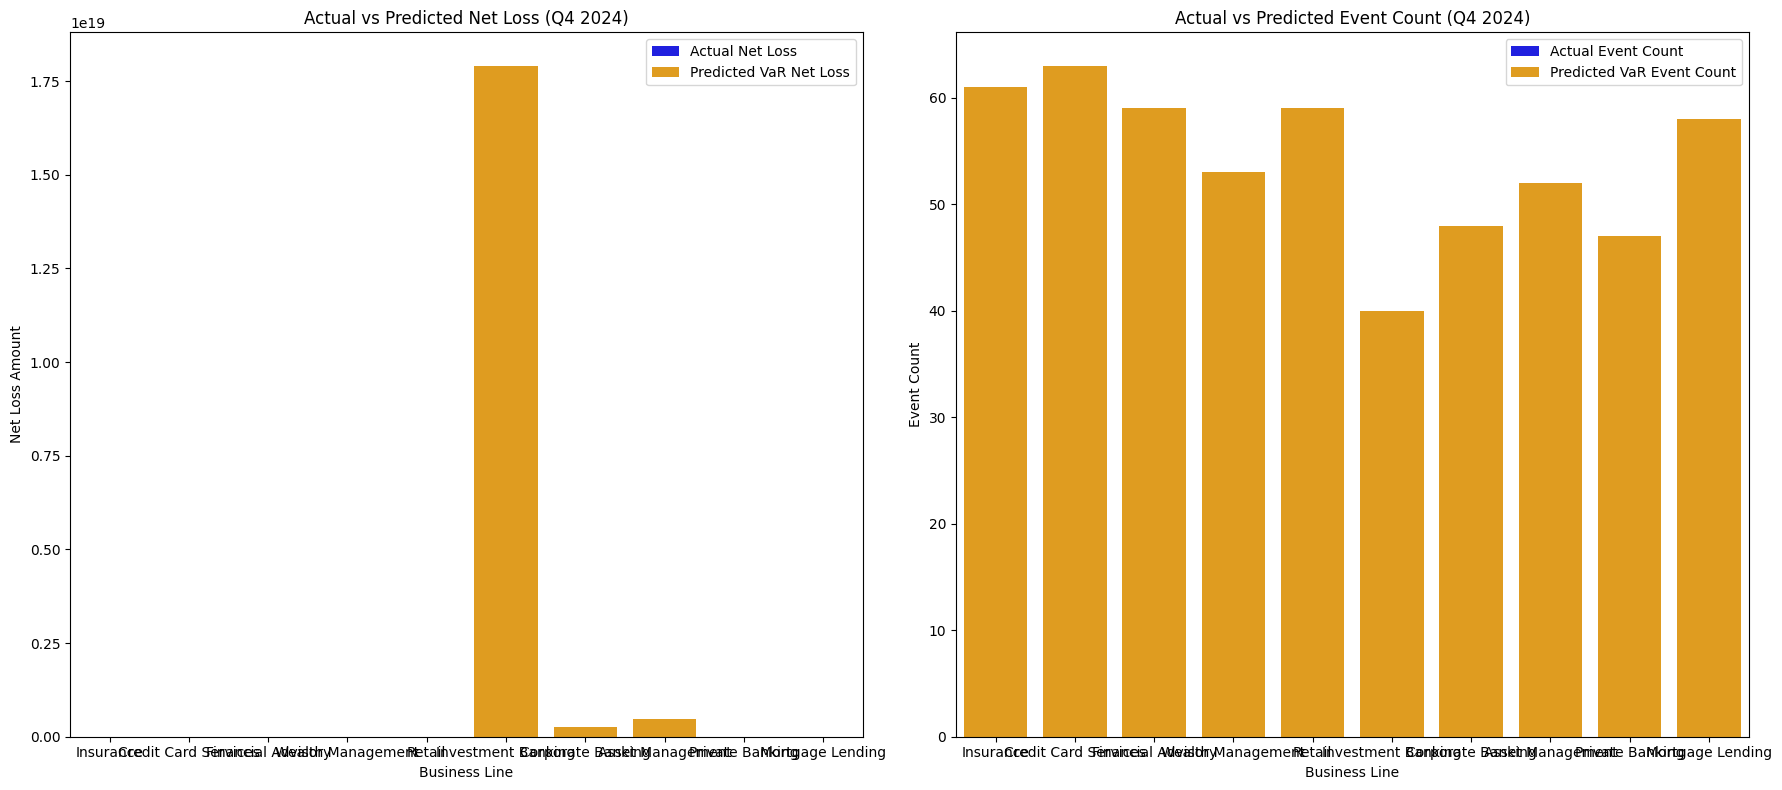

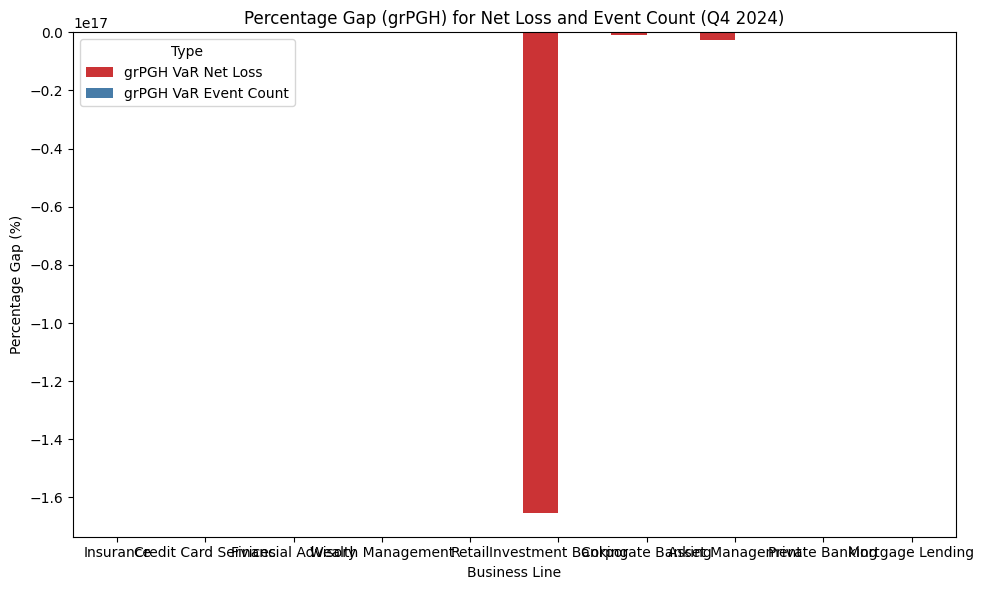

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a bar plot for actual vs predicted values for Net Loss and Event Count
def plot_comparison(df):
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot Actual vs Predicted Net Loss for each Business Line
    sns.barplot(
        x='Business Line', y='Actual Net Loss', data=df, color='blue', ax=axes[0], label='Actual Net Loss'
    )
    sns.barplot(
        x='Business Line', y='Predicted VaR Net Loss (99.9%)', data=df, color='orange', ax=axes[0], label='Predicted VaR Net Loss'
    )
    axes[0].set_title('Actual vs Predicted Net Loss (Q4 2024)')
    axes[0].set_xlabel('Business Line')
    axes[0].set_ylabel('Net Loss Amount')
    axes[0].legend()

    # Plot Actual vs Predicted Event Count for each Business Line
    sns.barplot(
        x='Business Line', y='Actual Event Count', data=df, color='blue', ax=axes[1], label='Actual Event Count'
    )
    sns.barplot(
        x='Business Line', y='Predicted VaR Event Count (99.9%)', data=df, color='orange', ax=axes[1], label='Predicted VaR Event Count'
    )
    axes[1].set_title('Actual vs Predicted Event Count (Q4 2024)')
    axes[1].set_xlabel('Business Line')
    axes[1].set_ylabel('Event Count')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Create a bar plot for the Percentage Gap (grPGH) for both Net Loss and Event Count
def plot_grPGH(df):
    # Create a new dataframe with the percentage gap
    grPGH_df = df[['Business Line', 'grPGH VaR Net Loss', 'grPGH VaR Event Count']]

    # Reshape the data for better plotting
    grPGH_df = grPGH_df.melt(id_vars='Business Line', var_name='Type', value_name='Percentage Gap')

    # Set up the figure
    plt.figure(figsize=(10, 6))

    # Plot the Percentage Gap (grPGH)
    sns.barplot(x='Business Line', y='Percentage Gap', hue='Type', data=grPGH_df, palette='Set1')

    plt.title('Percentage Gap (grPGH) for Net Loss and Event Count (Q4 2024)')
    plt.xlabel('Business Line')
    plt.ylabel('Percentage Gap (%)')
    plt.tight_layout()
    plt.show()

# Visualize the results
plot_comparison(comparison_df)
plot_grPGH(comparison_df)


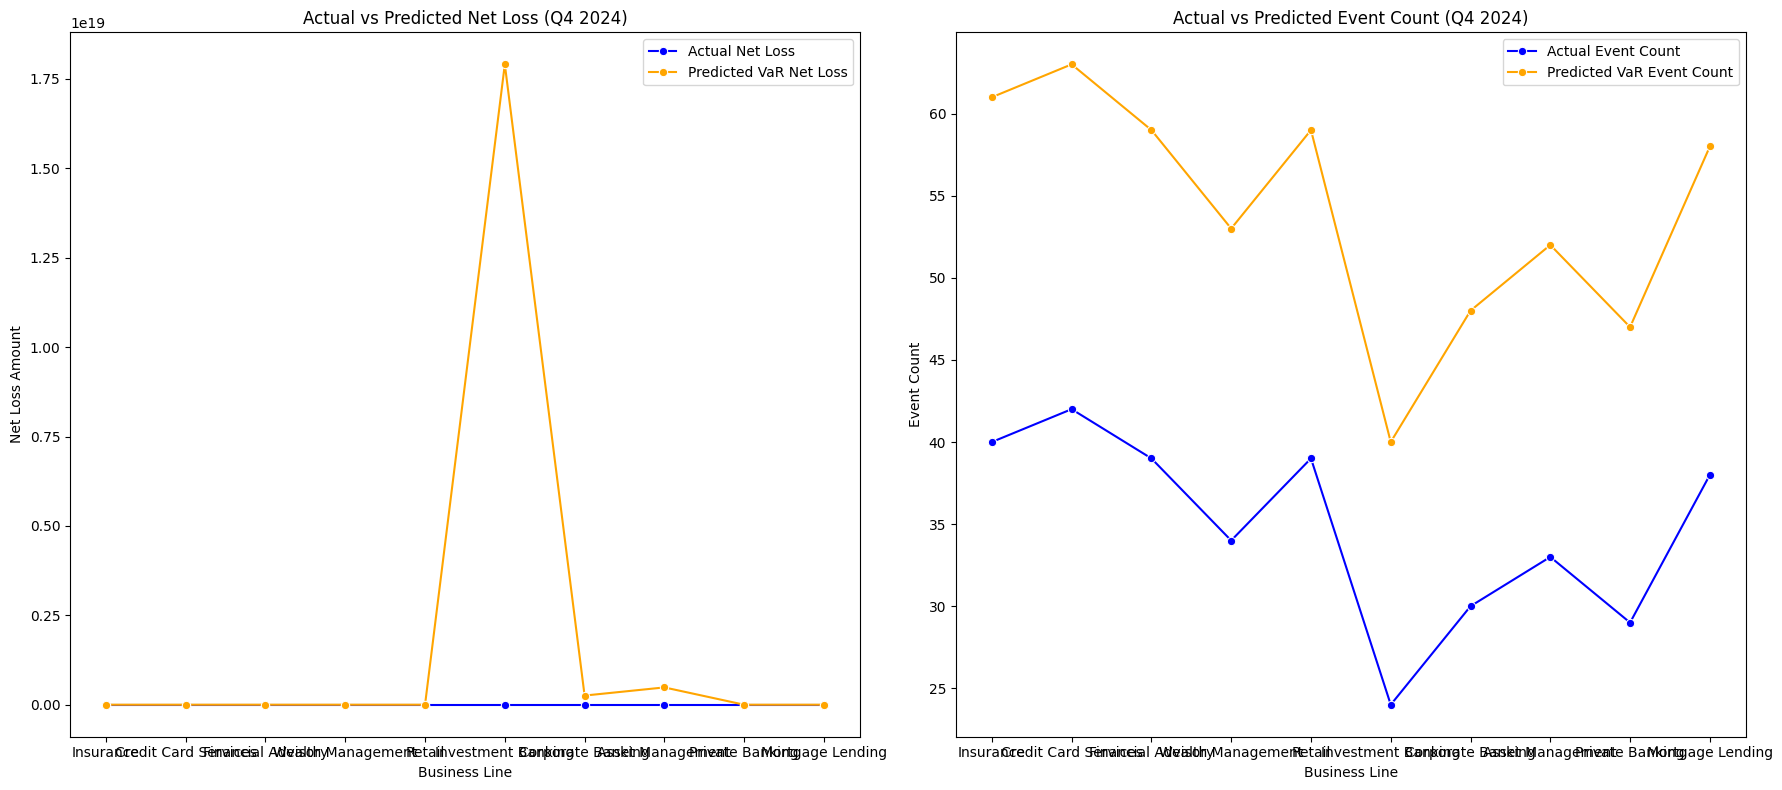

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a line graph for Actual vs Predicted Net Loss for each Business Line
def plot_line_comparison(df):
    # Set up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Plot Actual vs Predicted Net Loss for each Business Line
    sns.lineplot(
        x='Business Line', y='Actual Net Loss', data=df, marker='o', color='blue', ax=axes[0], label='Actual Net Loss'
    )
    sns.lineplot(
        x='Business Line', y='Predicted VaR Net Loss (99.9%)', data=df, marker='o', color='orange', ax=axes[0], label='Predicted VaR Net Loss'
    )
    axes[0].set_title('Actual vs Predicted Net Loss (Q4 2024)')
    axes[0].set_xlabel('Business Line')
    axes[0].set_ylabel('Net Loss Amount')
    axes[0].legend()

    # Plot Actual vs Predicted Event Count for each Business Line
    sns.lineplot(
        x='Business Line', y='Actual Event Count', data=df, marker='o', color='blue', ax=axes[1], label='Actual Event Count'
    )
    sns.lineplot(
        x='Business Line', y='Predicted VaR Event Count (99.9%)', data=df, marker='o', color='orange', ax=axes[1], label='Predicted VaR Event Count'
    )
    axes[1].set_title('Actual vs Predicted Event Count (Q4 2024)')
    axes[1].set_xlabel('Business Line')
    axes[1].set_ylabel('Event Count')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# Visualize the results using line graphs
plot_line_comparison(comparison_df)


    Year         Business Line  Total Event Count  Total Net Loss  \
0   2021    Investment Banking                228   572012.374395   
1   2021    Financial Advisory                267   632152.175660   
2   2021     Corporate Banking                264   529400.742383   
3   2021     Wealth Management                269   727495.874158   
4   2021      Asset Management                259   673726.389961   
5   2021       Private Banking                254   648716.078630   
6   2021             Insurance                266   709716.995975   
7   2021      Mortgage Lending                282   803131.187101   
8   2021                Retail                262   619566.564015   
9   2021  Credit Card Services                245   590713.028307   
10  2022    Investment Banking                257   665054.796407   
11  2022     Wealth Management                235   693599.119306   
12  2022  Credit Card Services                229   575827.434046   
13  2022       Private Banking    

In [5]:
lda_results_df

,Year,Business Line,Total Event Count,Total Net Loss,VaR Net Loss (99.9%)
0,2021,Investment Banking,228,572012.374395,3.461142e+06
1,2021,Financial Advisory,267,632152.175660,3.777399e+06
2,2021,Corporate Banking,264,529400.742383,6.583621e+06
3,2021,Wealth Management,269,727495.874158,3.908125e+06
4,2021,Asset Management,259,673726.389961,3.809334e+06
5,2021,Private Banking,254,648716.078630,3.680132e+06
6,2021,Insurance,266,709716.995975,3.691200e+06
7,2021,Mortgage Lending,282,803131.187101,4.189989e+06
8,2021,Retail,262,619566.564015,4.398374e+06
9,2021,Credit Card Services,245,590713.028307,3.544093e+06


In [2]:
results = []

years = [2021, 2022, 2023, 2024]
confidence_level = 0.999
n_simulations = 10000

for year in years:
    # Filter data for the year
    yearly_data = df[df['Year'] == year]
    
    # Average event counts for each business line
    event_count_avg = yearly_data.groupby(['Business Line', 'Event Type']).agg(
        Event_Count_Avg=('Unique Event ID', 'count')
    ).reset_index()
    
    # Fit loss distribution
    negative_losses = yearly_data[yearly_data['Net Loss Amount'] < 0]
    if negative_losses.empty:
        positive_losses = yearly_data[yearly_data['Net Loss Amount'] > 0]
        shape, loc, scale = stats.lognorm.fit(positive_losses['Net Loss Amount'])
    else:
        shape, loc, scale = stats.lognorm.fit(negative_losses['Net Loss Amount'] * -1)
    
    # Monte Carlo simulation for each business line
    for business_line in yearly_data['Business Line'].unique():
        business_data = event_count_avg[event_count_avg['Business Line'] == business_line]
        
        if not business_data.empty:
            # Simulate event counts
            avg_event_count = business_data['Event_Count_Avg'].mean()
            simulated_event_counts = np.random.poisson(lam=avg_event_count, size=n_simulations)
            
            # Simulate losses
            simulated_losses = stats.lognorm.rvs(s=shape, loc=loc, scale=scale, size=n_simulations)
            
            # Calculate VaR
            var_event_count = np.percentile(simulated_event_counts, (1 - confidence_level) * 100)
            var_net_loss = np.percentile(simulated_losses, (1 - confidence_level) * 100)
            
            # Aggregate results
            results.append({
                'Year': year,
                'Business Line': business_line,
                'Total Event Count': avg_event_count * len(yearly_data['Event Type'].unique()),  # Approximation
                'Total Net Loss': yearly_data[yearly_data['Business Line'] == business_line]['Net Loss Amount'].sum(),
                'VaR Event Count (99.9%)': var_event_count,
                'VaR Net Loss (99.9%)': var_net_loss
            })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)


    Year         Business Line  Total Event Count  Total Net Loss  \
0   2021    Investment Banking              228.0    14888.328732   
1   2021    Financial Advisory              267.0   -40865.052192   
2   2021     Corporate Banking              264.0  -155245.996109   
3   2021     Wealth Management              269.0    38788.016635   
4   2021      Asset Management              259.0   -10554.428223   
5   2021       Private Banking              254.0   -16360.014481   
6   2021             Insurance              266.0    42524.012453   
7   2021      Mortgage Lending              282.0   130123.253783   
8   2021                Retail              262.0   -25914.413844   
9   2021  Credit Card Services              245.0   -30027.265327   
10  2022    Investment Banking              257.0    80983.758280   
11  2022     Wealth Management              235.0    98691.620132   
12  2022  Credit Card Services              229.0    47102.153135   
13  2022       Private Banking    

In [3]:
results_df

,Year,Business Line,Total Event Count,Total Net Loss,VaR Event Count (99.9%),VaR Net Loss (99.9%)
0,2021,Investment Banking,228.0,14888.328732,9.999,-3718.622210
1,2021,Financial Advisory,267.0,-40865.052192,13.000,-4164.464333
2,2021,Corporate Banking,264.0,-155245.996109,12.000,-3433.415195
3,2021,Wealth Management,269.0,38788.016635,13.000,-3368.251280
4,2021,Asset Management,259.0,-10554.428223,12.000,-3541.320838
5,2021,Private Banking,254.0,-16360.014481,11.000,-3239.589840
6,2021,Insurance,266.0,42524.012453,12.000,-3311.956123
7,2021,Mortgage Lending,282.0,130123.253783,13.000,-3726.109853
8,2021,Retail,262.0,-25914.413844,12.000,-3623.943775
9,2021,Credit Card Services,245.0,-30027.265327,11.000,-3670.013894
